## Wielomiany interpolujące

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sympy as sym
from sympy import latex
from sympy.printing import cxxcode

import re

from IPython.display import display, Latex

Używamy wielomianów trzeciego rzędu, które pozwalają na zagwarantowanie ciągłości funkcji i pochodnych.

In [2]:
Φ = np.linalg.inv(np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [1, 1, 1, 1],
    [0, 1, 2, 3]
])).T
for a in Φ:
    print("φ(ξ) = {:2g}ξ³{:+g}ξ²{:+g}ξ{:+g}".format(*reversed(a)))

φ(ξ) =  2ξ³-3ξ²+0ξ+1
φ(ξ) =  1ξ³-2ξ²+1ξ+0
φ(ξ) = -2ξ³+3ξ²+0ξ+0
φ(ξ) =  1ξ³-1ξ²+0ξ+0


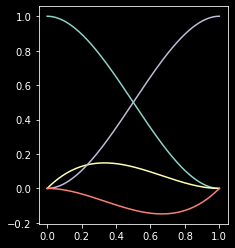

In [3]:
plt.axes(aspect='equal')
x = np.linspace(0, 1, 1001)
for p in Φ:
    y = sum(c * x**i for i,c in enumerate(p))
    plt.plot(x, y)
plt.show()

# Równanie dyfuzji nośników

Równanie do rozwiązania ma postać:
$$
D \Delta u - A u - B u^2 - C u^3 + J = 0,
$$
gdzie
$$
J = \frac{j_\perp}{q_e\,d},
$$
w którym $j_\perp$ to wstrzykiwana gęstość prądu a $d$ to grubość złącza. Po zamianie na równanie linowe (korzystając z rozwinięcia w szereg Taylora) mamy:
$$
D \Delta u - E u + F = 0,
$$
gdzie
\begin{align}
E & = A + 2 B u_0 + 3 C u_0^2 \\
F & = B u_0^2 + 2 C u_0^3 + J_0
\end{align}

In [4]:
A, B, C, D, L = sym.symbols('A B C D L')

Zastosujmy metodę Ritza w we współrzędnych kartezjańskich i biegunowych.

In [5]:
x, r, R = sym.symbols('x r R')

ξ = x / L

r1 = R
r2 = R + L
ξr = (r - r1) / L

Funkcje próbne mają postać:

In [6]:
φ = [sum(int(c) * ξ**i for i,c in enumerate(p)) for p in Φ]
φ[1] *= L
φ[3] *= L
φ = np.array([sym.expand(a) for a in φ])
dφ = np.array([sym.expand(sym.diff(a, x)) for a in φ])

In [7]:
display(Latex("\\begin{align}\n" +
    ' \\\\\n'.join(f'\\varphi_{i}(x) & = {latex(p)}' for i,p in enumerate(φ))
    + "\n\\end{align}\n"))


<IPython.core.display.Latex object>

A ich pochodne:

In [8]:
display(Latex("\\begin{align}\n" +
    ' \\\\\n'.join(f'\\frac{{d\\varphi_{i}}}{{dx}} & = {latex(p)}' for i,p in enumerate(dφ))
    + "\n\\end{align}\n"))


<IPython.core.display.Latex object>

## Funkcja przybliżana

Zakładamy, że
$$
u(\xi) = \sum_i u^i \, \varphi_i(\xi) \qquad u_0(\xi) = \sum_i U^i \,\varphi_i(\xi)
$$
gdzie
\begin{align}
u^0, u^1, u^2, u^3 & = u(0), \left.\tfrac{du}{dx}\right|_0, u(L), \left.\tfrac{du}{dx}\right|_L \\
U^0, U^1, U^2, U^3 & = u_0(0), \left.\tfrac{du_0}{dx}\right|_0, u_0(L), \left.\tfrac{du_0}{dx}\right|_L
\end{align}

In [9]:
_u0 = sym.IndexedBase('U', shape=(4,))
u0 = sum(_u0[k] * φ[k] for k in range(4))
u0

(3*x**2/L**2 - 2*x**3/L**3)*U[2] + (-x**2/L + x**3/L**2)*U[3] + (1 - 3*x**2/L**2 + 2*x**3/L**3)*U[0] + (x - 2*x**2/L + x**3/L**2)*U[1]

## Interpolacja prądu

Aby dobrze odzdwierciedlić rozpływ prądu, zakładamy, że na elemencie zmienia się on co najwużj liniowo

In [10]:
z = np.array([0, L])
sym.Array(z)

[0, L]

a we współrzędnych biegunowych

In [11]:
zr = z + r1
sym.Array(zr)

[R, L + R]

Teraz zakładmy, że w tych punktach mamy wartości funkcji $J$. Budujemy wielomiany interpolacyjne.

In [12]:
J = sym.IndexedBase('J', shape=(2,))

def La(i, x, z):
    res = 1
    for j in range(len(z)):
        if j == i: continue
        res *= (x - z[j]) / (z[i] - z[j])
    return res

In [13]:
Jx = sym.simplify(sum(J[i] * La(i, x, z) for i in range(len(z))))
Jx

(x*J[1] + (L - x)*J[0])/L

In [14]:
Jr = sym.simplify(sum(J[i] * La(i, r, zr) for i in range(len(zr))))
Jr

(-(R - r)*J[1] + (L + R - r)*J[0])/L

# Macierze sztywności i wektor obciążeń

In [15]:
ii, jj  = np.meshgrid(range(4), range(4))
i_ = np.arange(4)

## Kartezjańsko


Macierz sztywności budujemy z równania
$$
\left( - D \frac{d^2}{dx^2} + A + 2 B u_0 + 3 C u_0^2 \right) u = B u_0^2 + 2 C u_0^3 + J_0.
$$
Pamiętając, że
$$
u(\xi) = \sum_i u^i \, \varphi_i(x)
$$
i stosując metodę Ritza mamy
$$
\sum_j \int_0^L \left[ D \frac{d\varphi_i}{dx} \frac{d\varphi_j}{dx} + \left( A + 2 B u_0 + 3 C u_0^2 \right) \varphi_i \varphi_j \right] u^j = \left( B u_0^2 + 2 C u_0^3 + J_0 \right) \varphi_i.
$$

Do tego, stosując
$$
u_0(\xi) = \sum_i a^i \,\varphi_i(x)
$$
Mamy

In [16]:
KD = sym.simplify(sym.integrate(sym.Matrix(D * dφ[ii] * dφ[jj]), (x, 0, L)))
KA = sym.simplify(sym.integrate(sym.Matrix(A * φ[ii] * φ[jj]), (x, 0, L)))
KB = sym.simplify(sym.integrate(sym.Matrix(2 * B * u0 * φ[ii] * φ[jj]), (x, 0, L)))
KC = sym.simplify(sym.integrate(sym.Matrix(3 * C * u0**2 * φ[ii] * φ[jj]), (x, 0, L)))
K = KD + KA + KB + KC
K

Matrix([
[  13*A*L/35 + B*L*(97*L*U[1] - 43*L*U[3] + 774*U[0] + 162*U[2])/1260 + C*L*(840*L**2*U[1]**2 - 777*L**2*U[1]*U[3] + 268*L**2*U[3]**2 + 11004*L*U[0]*U[1] - 4011*L*U[0]*U[3] + 2867*L*U[1]*U[2] - 2138*L*U[2]*U[3] + 48132*U[0]**2 + 14418*U[0]*U[2] + 4374*U[2]**2)/60060 + 6*D/(5*L), 11*A*L**2/210 + B*L**2*(16*L*U[1] - 9*L*U[3] + 97*U[0] + 35*U[2])/1260 + C*L**2*(294*L**2*U[1]**2 - 322*L**2*U[1]*U[3] + 125*L**2*U[3]**2 + 3360*L*U[0]*U[1] - 1554*L*U[0]*U[3] + 1216*L*U[1]*U[2] - 1020*L*U[2]*U[3] + 11004*U[0]**2 + 5734*U[0]*U[2] + 2138*U[2]**2)/120120 + D/10,         9*A*L/70 + B*L*(35*L*U[1] - 35*L*U[3] + 162*U[0] + 162*U[2])/1260 + C*L*(304*L**2*U[1]**2 - 510*L**2*U[1]*U[3] + 304*L**2*U[3]**2 + 2867*L*U[0]*U[1] - 2138*L*U[0]*U[3] + 2138*L*U[1]*U[2] - 2867*L*U[2]*U[3] + 7209*U[0]**2 + 8748*U[0]*U[2] + 7209*U[2]**2)/60060 - 6*D/(5*L),   -13*A*L**2/420 + B*L**2*(-9*L*U[1] + 8*L*U[3] - 43*U[0] - 35*U[2])/1260 + C*L**2*(-161*L**2*U[1]**2 + 250*L**2*U[1]*U[3] - 135*L**2*U[3]**2 - 1554*L*U

In [17]:
FB = sym.simplify(sym.integrate(sym.Matrix(B * u0**2 * φ[i_]), (x, 0, L)))
FC = sym.simplify(sym.integrate(sym.Matrix(2 * C * u0**3 * φ[i_]), (x, 0, L)))
F0 = sym.simplify(sym.integrate(sym.Matrix(Jx * φ[i_]), (x, 0, L)))
F = FB + FC + F0
F

Matrix([
[   B*L*(8*L**2*U[1]**2 - 9*L**2*U[1]*U[3] + 4*L**2*U[3]**2 + 97*L*U[0]*U[1] - 43*L*U[0]*U[3] + 35*L*U[1]*U[2] - 35*L*U[2]*U[3] + 387*U[0]**2 + 162*U[0]*U[2] + 81*U[2]**2)/1260 + C*L*(98*L**3*U[1]**3 - 161*L**3*U[1]**2*U[3] + 125*L**3*U[1]*U[3]**2 - 45*L**3*U[3]**3 + 1680*L**2*U[0]*U[1]**2 - 1554*L**2*U[0]*U[1]*U[3] + 536*L**2*U[0]*U[3]**2 + 608*L**2*U[1]**2*U[2] - 1020*L**2*U[1]*U[2]*U[3] + 608*L**2*U[2]*U[3]**2 + 11004*L*U[0]**2*U[1] - 4011*L*U[0]**2*U[3] + 5734*L*U[0]*U[1]*U[2] - 4276*L*U[0]*U[2]*U[3] + 2138*L*U[1]*U[2]**2 - 2867*L*U[2]**2*U[3] + 32088*U[0]**3 + 14418*U[0]**2*U[2] + 8748*U[0]*U[2]**2 + 4806*U[2]**3)/60060 + L*(7*J[0] + 3*J[1])/20],
[  B*L**2*(3*L**2*U[1]**2 - 4*L**2*U[1]*U[3] + 2*L**2*U[3]**2 + 32*L*U[0]*U[1] - 18*L*U[0]*U[3] + 16*L*U[1]*U[2] - 18*L*U[2]*U[3] + 97*U[0]**2 + 70*U[0]*U[2] + 43*U[2]**2)/2520 + C*L**2*(56*L**3*U[1]**3 - 105*L**3*U[1]**2*U[3] + 90*L**3*U[1]*U[3]**2 - 35*L**3*U[3]**3 + 882*L**2*U[0]*U[1]**2 - 966*L**2*U[0]*U[1]*U[3] + 375*L**2*U[

In [18]:
def cpp(v):
    s = cxxcode(v, standard='C++11')
    #for i in range(1, 5):
    #    s = s.replace(f"a[{i}]", f"a{i}")
    s = re.sub(r'std::pow\(([^)]+), (\d+)\)', r'std::pow(\1,\2)', s)
    s = re.sub(r'std::pow\(([^)]+),2\)', r'\1*\1', s)
    s = re.sub(r'std::pow\(([^)]+),3\)', r'\1*\1*\1', s)
    return s.replace('_', '')

def print_cpp(K, F):
    print('{')
    for i in range(4):
        for j in range(i, 4):
            print(f"    K{i}{j} += {cpp(K[i,j])};")
    for i in range(4):
        print(f"    F{i} += {cpp(F[i])};")
    print('}')

In [19]:
print_cpp(K, F)

{
    K00 += (13.0/35.0)*A*L + (1.0/1260.0)*B*L*(97*L*U[1] - 43*L*U[3] + 774*U[0] + 162*U[2]) + (1.0/60060.0)*C*L*(840*L*L*U[1]*U[1] - 777*L*L*U[1]*U[3] + 268*L*L*U[3]*U[3] + 11004*L*U[0]*U[1] - 4011*L*U[0]*U[3] + 2867*L*U[1]*U[2] - 2138*L*U[2]*U[3] + 48132*U[0]*U[0] + 14418*U[0]*U[2] + 4374*U[2]*U[2]) + (6.0/5.0)*D/L;
    K01 += (11.0/210.0)*A*L*L + (1.0/1260.0)*B*L*L*(16*L*U[1] - 9*L*U[3] + 97*U[0] + 35*U[2]) + (1.0/120120.0)*C*L*L*(294*L*L*U[1]*U[1] - 322*L*L*U[1]*U[3] + 125*L*L*U[3]*U[3] + 3360*L*U[0]*U[1] - 1554*L*U[0]*U[3] + 1216*L*U[1]*U[2] - 1020*L*U[2]*U[3] + 11004*U[0]*U[0] + 5734*U[0]*U[2] + 2138*U[2]*U[2]) + (1.0/10.0)*D;
    K02 += (9.0/70.0)*A*L + (1.0/1260.0)*B*L*(35*L*U[1] - 35*L*U[3] + 162*U[0] + 162*U[2]) + (1.0/60060.0)*C*L*(304*L*L*U[1]*U[1] - 510*L*L*U[1]*U[3] + 304*L*L*U[3]*U[3] + 2867*L*U[0]*U[1] - 2138*L*U[0]*U[3] + 2138*L*U[1]*U[2] - 2867*L*U[2]*U[3] + 7209*U[0]*U[0] + 8748*U[0]*U[2] + 7209*U[2]*U[2]) - 6.0/5.0*D/L;
    K03 += -13.0/420.0*A*L*L + (1.0/1260.0)*B

## Cylindrycznie

In [20]:
φr = [sum(int(c) * ξr**i for i,c in enumerate(p)) for p in Φ]
φr[1] *= L
φr[3] *= L
φr = np.array([sym.simplify(a) for a in φr])
dφr = np.array([sym.simplify(sym.diff(a, r)) for a in φr])

In [21]:
display(Latex("\\begin{align}\n" +
    ' \\\\\n'.join(f'\\varphi_{i}(r) & = {latex(p)}' for i,p in enumerate(φr))
    + "\n\\end{align}\n"))

<IPython.core.display.Latex object>

In [22]:
display(Latex("\\begin{align}\n" +
    ' \\\\\n'.join(f'\\frac{{d\\varphi_{i}}}{{dr}} & = {latex(p)}' for i,p in enumerate(dφr))
    + "\n\\end{align}\n"))

<IPython.core.display.Latex object>

In [23]:
u0r = sum(_u0[k] * φr[k] for k in range(4))
u0r

(-R + r - 2*(R - r)**2/L - (R - r)**3/L**2)*U[1] + (R - r)**2*(-L - R + r)*U[3]/L**2 + (R - r)**2*(3*L + 2*R - 2*r)*U[2]/L**3 + (L**3 - 3*L*(R - r)**2 - 2*(R - r)**3)*U[0]/L**3

In [24]:
KrD = sym.simplify(sym.integrate(sym.Matrix(r * D * dφr[ii] * dφr[jj]), (r, r1, r2)))
KrA = sym.simplify(sym.integrate(sym.Matrix(r * A * φr[ii] * φr[jj]), (r, r1, r2)))
KrB = sym.simplify(sym.integrate(sym.Matrix(r * 2 * B * u0r * φr[ii] * φr[jj]), (r, r1, r2)))
KrC = sym.simplify(sym.integrate(sym.Matrix(r * 3 * C * u0r**2 * φr[ii] * φr[jj]), (r, r1, r2)))
Kr = KrD + KrA + KrB + KrC
Kr = R * sym.simplify(sym.expand(Kr/R))
Kr

Matrix([
[                                          (432432*D*R + 2*L**2*R*(66924*A + 13871*B*L*U[1] - 6149*B*L*U[3] + 110682*B*U[0] + 23166*B*U[2] + 2520*C*L**2*U[1]**2 - 2331*C*L**2*U[1]*U[3] + 804*C*L**2*U[3]**2 + 33012*C*L*U[0]*U[1] - 12033*C*L*U[0]*U[3] + 8601*C*L*U[1]*U[2] - 6414*C*L*U[2]*U[3] + 144396*C*U[0]**2 + 43254*C*U[0]*U[2] + 13122*C*U[2]**2) + L*(30888*A*L**2 + 7540*B*L**3*U[1] - 4758*B*L**3*U[3] + 42822*B*L**2*U[0] + 18954*B*L**2*U[2] + 1458*C*L**4*U[1]**2 - 1746*C*L**4*U[1]*U[3] + 735*C*L**4*U[3]**2 + 15912*C*L**3*U[0]*U[1] - 8154*C*L**3*U[0]*U[3] + 6708*C*L**3*U[1]*U[2] - 6120*C*L**3*U[2]*U[3] + 48924*C*L**2*U[0]**2 + 30618*C*L**2*U[0]*U[2] + 13122*C*L**2*U[2]**2 + 216216*D))/(360360*L), A*L**3/60 + 19*B*L**4*U[1]/4620 - B*L**4*U[3]/330 + 29*B*L**3*U[0]/1386 + 43*B*L**3*U[2]/3465 + 4*C*L**5*U[1]**2/5005 - C*L**5*U[1]*U[3]/924 + C*L**5*U[3]**2/2002 + 81*C*L**4*U[0]*U[1]/10010 - 97*C*L**4*U[0]*U[3]/20020 + 17*C*L**4*U[1]*U[2]/4004 - 17*C*L**4*U[2]*U[3]/4004 + 17*C*L**3*

In [25]:
FrB = sym.simplify(sym.integrate(sym.Matrix(r * B * u0r**2 * φr[i_]), (r, r1, r2)))
FrC = sym.simplify(sym.integrate(sym.Matrix(r * 2 * C * u0r**3 * φr[i_]), (r, r1, r2)))
Fr0 = sym.simplify(sym.integrate(sym.Matrix(r * Jr * φr[i_]), (r, r1, r2)))
Fr = FrB + FrC + Fr0
Fr = R * sym.simplify(sym.expand(Fr/R))
Fr

Matrix([
[  L*(741*B*L**3*U[1]**2 - 1092*B*L**3*U[1]*U[3] + 598*B*L**3*U[3]**2 + 7540*B*L**2*U[0]*U[1] - 4758*B*L**2*U[0]*U[3] + 4472*B*L**2*U[1]*U[2] - 5538*B*L**2*U[2]*U[3] + 21411*B*L*U[0]**2 + 18954*B*L*U[0]*U[2] + 13689*B*L*U[2]**2 + 192*C*L**4*U[1]**3 - 390*C*L**4*U[1]**2*U[3] + 360*C*L**4*U[1]*U[3]**2 - 150*C*L**4*U[3]**3 + 2916*C*L**3*U[0]*U[1]**2 - 3492*C*L**3*U[0]*U[1]*U[3] + 1470*C*L**3*U[0]*U[3]**2 + 1530*C*L**3*U[1]**2*U[2] - 3060*C*L**3*U[1]*U[2]*U[3] + 2118*C*L**3*U[2]*U[3]**2 + 15912*C*L**2*U[0]**2*U[1] - 8154*C*L**2*U[0]**2*U[3] + 13416*C*L**2*U[0]*U[1]*U[2] - 12240*C*L**2*U[0]*U[2]*U[3] + 6708*C*L**2*U[1]*U[2]**2 - 10494*C*L**2*U[2]**2*U[3] + 32616*C*L*U[0]**3 + 30618*C*L*U[0]**2*U[2] + 26244*C*L*U[0]*U[2]**2 + 18630*C*L*U[2]**3 + 30030*L*J[0] + 24024*L*J[1] + 2*R*(1144*B*L**2*U[1]**2 - 1287*B*L**2*U[1]*U[3] + 572*B*L**2*U[3]**2 + 13871*B*L*U[0]*U[1] - 6149*B*L*U[0]*U[3] + 5005*B*L*U[1]*U[2] - 5005*B*L*U[2]*U[3] + 55341*B*U[0]**2 + 23166*B*U[0]*U[2] + 11583*B*U[2]**2 

In [26]:
print_cpp(Kr, Fr)

{
    K00 += (1.0/360360.0)*(432432*D*R + 2*L*L*R*(66924*A + 13871*B*L*U[1] - 6149*B*L*U[3] + 110682*B*U[0] + 23166*B*U[2] + 2520*C*L*L*U[1]*U[1] - 2331*C*L*L*U[1]*U[3] + 804*C*L*L*U[3]*U[3] + 33012*C*L*U[0]*U[1] - 12033*C*L*U[0]*U[3] + 8601*C*L*U[1]*U[2] - 6414*C*L*U[2]*U[3] + 144396*C*U[0]*U[0] + 43254*C*U[0]*U[2] + 13122*C*U[2]*U[2]) + L*(30888*A*L*L + 7540*B*L*L*L*U[1] - 4758*B*L*L*L*U[3] + 42822*B*L*L*U[0] + 18954*B*L*L*U[2] + 1458*C*std::pow(L,4)*U[1]*U[1] - 1746*C*std::pow(L,4)*U[1]*U[3] + 735*C*std::pow(L,4)*U[3]*U[3] + 15912*C*L*L*L*U[0]*U[1] - 8154*C*L*L*L*U[0]*U[3] + 6708*C*L*L*L*U[1]*U[2] - 6120*C*L*L*L*U[2]*U[3] + 48924*C*L*L*U[0]*U[0] + 30618*C*L*L*U[0]*U[2] + 13122*C*L*L*U[2]*U[2] + 216216*D))/L;
    K01 += (1.0/60.0)*A*L*L*L + (19.0/4620.0)*B*std::pow(L,4)*U[1] - 1.0/330.0*B*std::pow(L,4)*U[3] + (29.0/1386.0)*B*L*L*L*U[0] + (43.0/3465.0)*B*L*L*L*U[2] + (4.0/5005.0)*C*std::pow(L,5)*U[1]*U[1] - 1.0/924.0*C*std::pow(L,5)*U[1]*U[3] + (1.0/2002.0)*C*std::pow(L,5)*U[3]*U[3] +